# Multiclass Semantic Segmentation using WeedMap dataset

## Introduction
- Semantic Segmentation of an image is to assign each pixel in the input image a semantic class in order to get a pixel-wise dense classification.
- A general semantic segmentation architecture can be broadly thought of as an encoder network followed by a decoder network. - - The encoder is usually is a pre-trained classification network like VGG/ResNet followed by a decoder network. The decoder network/mechanism is mostly where these architectures differ. 
- The task of the decoder is to semantically project the discriminative features (lower resolution) learnt by the encoder onto the pixel space (higher resolution) to get a dense classification. (mechanisms like skip connections, pyramid pooling etc are used for this)



## Importing libraries

In [91]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import re
import cv2
from PIL import Image
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, accuracy_score

import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import os
import sys
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *


#from tensorflow.keras.engine import Layer
from tensorflow.keras.applications.vgg16 import *
from tensorflow.keras.models import *
#from tensorflow.keras.applications.imagenet_utils import _obtain_input_shape
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Cropping2D, Conv2D
from tensorflow.keras.layers import Input, Add, Dropout, Permute, add
from tensorflow.compat.v1.layers import conv2d_transpose
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Environment checks

In [3]:
print(tf.__version__)

2.0.0


In [4]:
x = tf.random.uniform([3, 3])

print("Is there a GPU available: "),
print(tf.test.is_gpu_available())

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

print("Device name: {}".format((x.device)))

Is there a GPU available: 
True
Is the Tensor on GPU #0:  
True
Device name: /job:localhost/replica:0/task:0/device:GPU:0


In [5]:
122/123 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000 - tversky_loss: 2.0236 - dice_coef: 0.9782
Epoch 00090: val_dice_coef did not improve from 0.97959
123/123 [==============================] - 39s 315ms/step - loss: 0.0017 - accuracy: 1.0000 - tversky_loss: 2.0237 - dice_coef: 0.9782 - val_loss: 0.0017 - val_accuracy: 1.0000 - val_tversky_loss: 2.0238 - val_dice_coef: 0.9780
Epoch 91/100
122/123 [============================>.] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000 - tversky_loss: 2.0235 - dice_coef: 0.9782
Epoch 00091: val_dice_coef did not improve from 0.97959
123/123 [==============================] - 39s 315ms/step - loss: 0.0016 - accuracy: 1.0000 - tversky_loss: 2.0235 - dice_coef: 0.9782 - val_loss: 0.0016 - val_accuracy: 1.0000 - val_tversky_loss: 2.0224 - val_dice_coef: 0.9793
Epoch 92/100
122/123 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000 - tversky_loss: 2.0234 - dice_coef: 0.9782
Epoch 00092: val_dice_coef did not improve from 0.97959
123/123 [==============================] - 38s 313ms/step - loss: 0.0015 - accuracy: 1.0000 - tversky_loss: 2.0234 - dice_coef: 0.9782 - val_loss: 0.0015 - val_accuracy: 1.0000 - val_tversky_loss: 2.0228 - val_dice_coef: 0.9789
Epoch 93/100
122/123 [============================>.] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000 - tversky_loss: 2.0233 - dice_coef: 0.9782
Epoch 00093: val_dice_coef did not improve from 0.97959
123/123 [==============================] - 39s 314ms/step - loss: 0.0014 - accuracy: 1.0000 - tversky_loss: 2.0233 - dice_coef: 0.9782 - val_loss: 0.0014 - val_accuracy: 1.0000 - val_tversky_loss: 2.0233 - val_dice_coef: 0.9782
Epoch 94/100
122/123 [============================>.] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000 - tversky_loss: 2.0232 - dice_coef: 0.9782
Epoch 00094: val_dice_coef did not improve from 0.97959
123/123 [==============================] - 39s 314ms/step - loss: 0.0013 - accuracy: 1.0000 - tversky_loss: 2.0232 - dice_coef: 0.9782 - val_loss: 0.0013 - val_accuracy: 1.0000 - val_tversky_loss: 2.0236 - val_dice_coef: 0.9777
Epoch 95/100print(tf.executing_eagerly())

True


In [6]:
#!wget http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamSeq01/CamSeq01.zip

In [7]:
cwd = os.getcwd()
cwd

'/home/lisi2020/Downloads/Multiclass-Semantic-Segmentation-CamVid-master'

In [8]:
#!mkdir data
#!mkdir data/CamSeq01

In [9]:
#!unzip CamSeq01.zip -d data/CamSeq01

## Data preparation - Importing, Cleaning and Creating structured directory 

### Function to import and process frames and masks as tensors

In [10]:
def _read_to_tensor(fname, output_height=224, output_width=224, normalize_data=False):
    '''Function to read images from given image file path, and provide resized images as tensors
        Inputs: 
            fname - image file path
            output_height - required output image height
            output_width - required output image width
            normalize_data - if True, normalize data to be centered around 0 (mean 0, range 0 to 1)
        Output: Processed image tensors
    '''
    
    # Read the image as a tensor
    img_strings = tf.io.read_file(fname)
    imgs_decoded = tf.image.decode_jpeg(img_strings)

    # Resize the image
    output = tf.image.resize(imgs_decoded, [output_height, output_width])
    # Normalize if required
    if normalize_data:
        output = (output - 128) / 128
    return output

### Image directory and size parameters

In [11]:
import shutil

## Try to remove tree; if failed show an error using try...except on screen
#shutil.rmtree("data/CamSeq01/train_frames")
#shutil.rmtree("data/CamSeq01/train_masks")
#shutil.rmtree("data/CamSeq01/val_frames")
#shutil.rmtree("data/CamSeq01/val_masks")

img_dir = '/home/lisi2020/Downloads/Multiclass-Semantic-Segmentation-CamVid-master/RedEdge/'

# Required image dimensions
output_height = 224
output_width = 224

### Reading frames and masks
- Mask file names end in "\_L.png"


In [12]:
file_list = os.listdir(img_dir)
file_list

['val_masks',
 'test_masks',
 'train',
 'test',
 'val_frames',
 'label_colors.txt',
 'train_frames',
 'test_frames',
 'train_masks']

In [13]:
def read_images(img_dir):
    '''Function to get all image directories, read images and masks in separate tensors
        Inputs: 
            img_dir - file directory
        Outputs 
            frame_tensors, masks_tensors, frame files list, mask files list
    '''
    
    # Get the file names list from provided directory
    file_list = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]
    
    # Separate frame and mask files lists, exclude unnecessary files
    frames_list = [file for file in file_list if ('_L' not in file) and ('txt' not in file)]
    masks_list = [file for file in file_list if ('_L' in file) and ('txt' not in file)]
    
    frames_list = sorted(frames_list)
    masks_list = sorted(masks_list)
    
    print('{} frame files found in the provided directory.'.format(len(frames_list)))
    print('{} mask files found in the provided directory.'.format(len(masks_list)))
    
    # Create file paths from file names
    frames_paths = [os.path.join(img_dir, fname) for fname in frames_list]
    masks_paths = [os.path.join(img_dir, fname) for fname in masks_list]
    
    # Create dataset of tensors
    frame_data = tf.data.Dataset.from_tensor_slices(frames_paths)
    masks_data = tf.data.Dataset.from_tensor_slices(masks_paths)
    
    # Read images into the tensor dataset
    frame_tensors = frame_data.map(_read_to_tensor)
    masks_tensors = masks_data.map(_read_to_tensor)
    
    print('Completed importing {} frame images from the provided directory.'.format(len(frames_list)))
    print('Completed importing {} mask images from the provided directory.'.format(len(masks_list)))
    
    return frame_tensors, masks_tensors, frames_list, masks_list

train_frame_tensors, train_masks_tensors, train_frames_list, train_masks_list = read_images(os.path.join(img_dir, "train"))
test_frame_tensors, test_masks_tensors, test_frames_list, test_masks_list = read_images(os.path.join(img_dir, "test"))                                                                   

766 frame files found in the provided directory.
766 mask files found in the provided directory.
Completed importing 766 frame images from the provided directory.
Completed importing 766 mask images from the provided directory.
204 frame files found in the provided directory.
204 mask files found in the provided directory.
Completed importing 204 frame images from the provided directory.
Completed importing 204 mask images from the provided directory.


In [14]:
#masks_list.sort()
#print(len(masks_list))
train_frames_list

['frame0000.png',
 'frame0001.png',
 'frame0002.png',
 'frame0003.png',
 'frame0004.png',
 'frame0005.png',
 'frame0006.png',
 'frame0007.png',
 'frame0008.png',
 'frame0009.png',
 'frame0010.png',
 'frame0011.png',
 'frame0012.png',
 'frame0013.png',
 'frame0014.png',
 'frame0015.png',
 'frame0016.png',
 'frame0017.png',
 'frame0018.png',
 'frame0019.png',
 'frame0020.png',
 'frame0021.png',
 'frame0022.png',
 'frame0023.png',
 'frame0024.png',
 'frame0025.png',
 'frame0026.png',
 'frame0027.png',
 'frame0028.png',
 'frame0029.png',
 'frame0030.png',
 'frame0031.png',
 'frame0032.png',
 'frame0033.png',
 'frame0034.png',
 'frame0035.png',
 'frame0036.png',
 'frame0037.png',
 'frame0038.png',
 'frame0039.png',
 'frame0040.png',
 'frame0041.png',
 'frame0042.png',
 'frame0043.png',
 'frame0044.png',
 'frame0045.png',
 'frame0046.png',
 'frame0047.png',
 'frame0048.png',
 'frame0049.png',
 'frame0050.png',
 'frame0051.png',
 'frame0052.png',
 'frame0053.png',
 'frame0054.png',
 'frame005

In [15]:
#frames_list.sort()
#print(len(frames_listf keras concatenatet))
train_masks_list

['frame0000_L.png',
 'frame0001_L.png',
 'frame0002_L.png',
 'frame0003_L.png',
 'frame0004_L.png',
 'frame0005_L.png',
 'frame0006_L.png',
 'frame0007_L.png',
 'frame0008_L.png',
 'frame0009_L.png',
 'frame0010_L.png',
 'frame0011_L.png',
 'frame0012_L.png',
 'frame0013_L.png',
 'frame0014_L.png',
 'frame0015_L.png',
 'frame0016_L.png',
 'frame0017_L.png',
 'frame0018_L.png',
 'frame0019_L.png',
 'frame0020_L.png',
 'frame0021_L.png',
 'frame0022_L.png',
 'frame0023_L.png',
 'frame0024_L.png',
 'frame0025_L.png',
 'frame0026_L.png',
 'frame0027_L.png',
 'frame0028_L.png',
 'frame0029_L.png',
 'frame0030_L.png',
 'frame0031_L.png',
 'frame0032_L.png',
 'frame0033_L.png',
 'frame0034_L.png',
 'frame0035_L.png',
 'frame0036_L.png',
 'frame0037_L.png',
 'frame0038_L.png',
 'frame0039_L.png',
 'frame0040_L.png',
 'frame0041_L.png',
 'frame0042_L.png',
 'frame0043_L.png',
 'frame0044_L.png',
 'frame0045_L.png',
 'frame0046_L.png',
 'frame0047_L.png',
 'frame0048_L.png',
 'frame0049_L.png',


### Displaying Images in the train dataset

In [16]:
# Make an iterator to extract images from the tensor dataset

train_frame_batches = tf.compat.v1.data.make_one_shot_iterator(train_frame_tensors)  # outside of TF Eager, we would use make_one_shot_iterator
train_mask_batches = tf.compat.v1.data.make_one_shot_iterator(train_masks_tensors)

#test_frame_batches = tf.compat.v1.data.make_one_shot_iterator(test_frame_tensors)  # outside of TF Eager, we would use make_one_shot_iterator
#test_masks_tensors = tf.compat.v1.data.make_one_shot_iterator(test_masks_tensors)

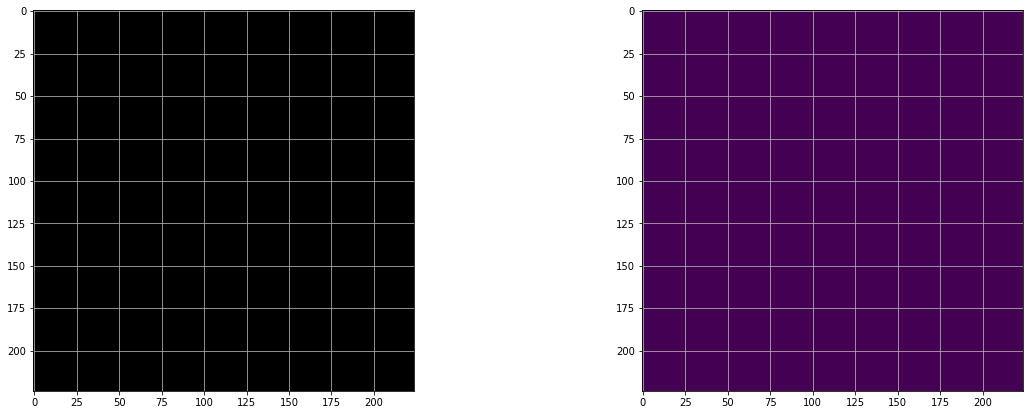

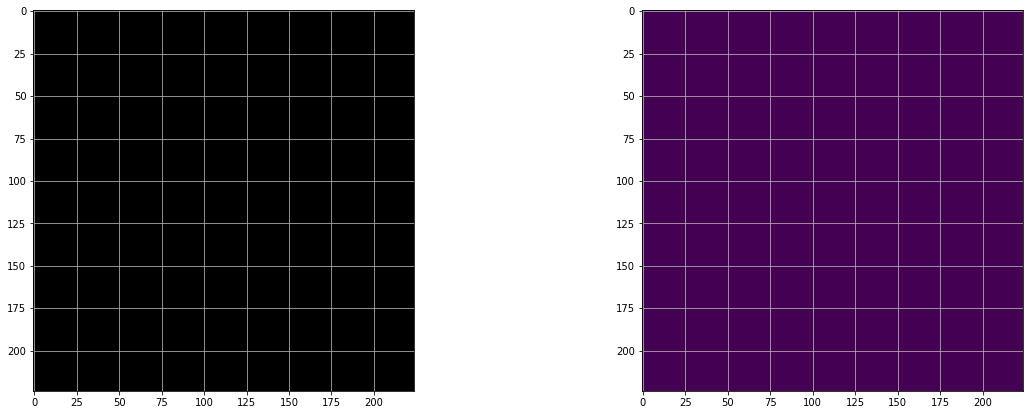

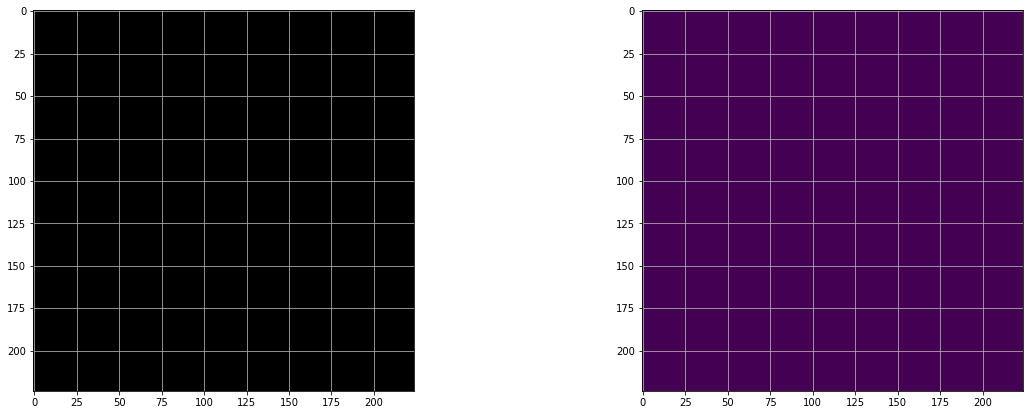

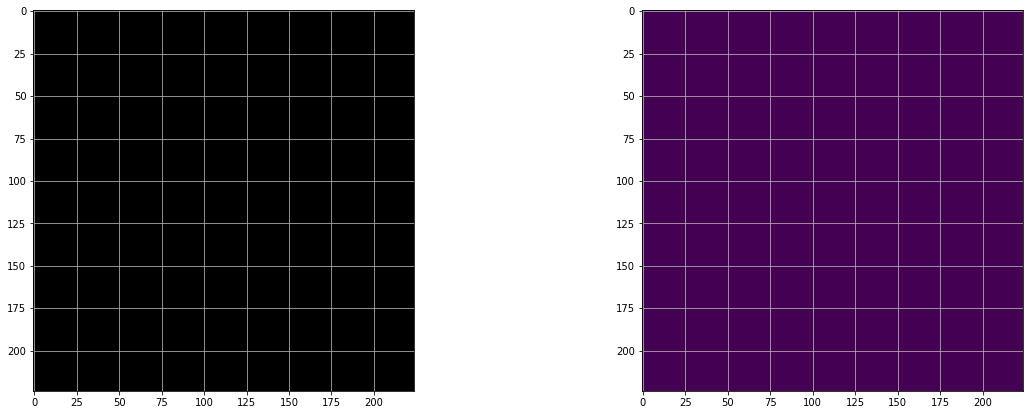

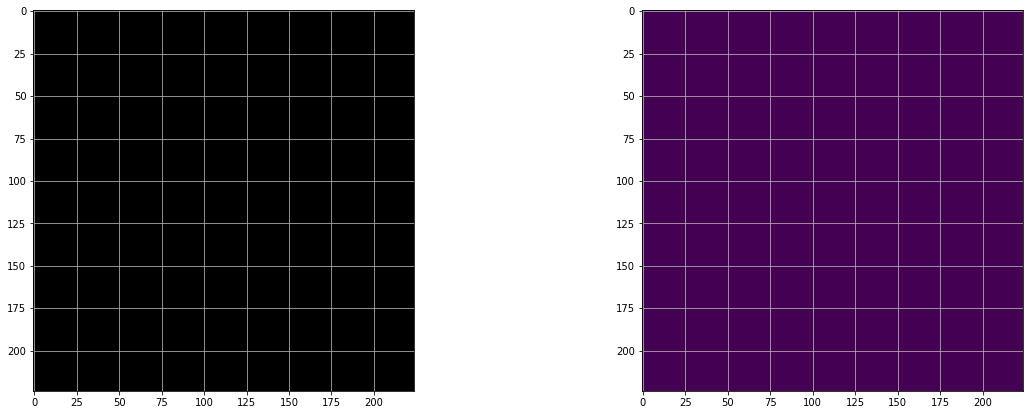

In [17]:
n_images_to_show = 5

for i in range(n_images_to_show):
    
    # Get the next image from iterator
    frame = train_frame_batches.next().numpy().astype(np.uint8)
    mask = train_mask_batches.next().numpy().astype(np.uint8)
    
    #Plot the corresponding frames and masks
    fig = plt.figure(figsize=(20,7))
    fig.add_subplot(1,2,1)
    plt.grid(b=None)
    plt.imshow(frame)
    fig.add_subplot(1,2,2)
    plt.grid(b=None)
    plt.imshow(np.squeeze(mask))
    plt.show()

### Creating folder structure common for Computer Vision problems

In [18]:
DATA_PATH = '/home/lisi2020/Downloads/Multiclass-Semantic-Segmentation-CamVid-master/RedEdge'

# Create folders to hold images and masks

folders = ['train_frames/train', 'train_masks/train', 'val_frames/val', 'val_masks/val']


for folder in folders:
    try:
        os.makedirs(os.path.join(DATA_PATH, folder))
    except Exception as e: print(e)

[Errno 17] File exists: '/home/lisi2020/Downloads/Multiclass-Semantic-Segmentation-CamVid-master/RedEdge/train_frames/train'
[Errno 17] File exists: '/home/lisi2020/Downloads/Multiclass-Semantic-Segmentation-CamVid-master/RedEdge/train_masks/train'
[Errno 17] File exists: '/home/lisi2020/Downloads/Multiclass-Semantic-Segmentation-CamVid-master/RedEdge/val_frames/val'
[Errno 17] File exists: '/home/lisi2020/Downloads/Multiclass-Semantic-Segmentation-CamVid-master/RedEdge/val_masks/val'


### Saving frames and masks to correct directories

In [19]:
frame_batches = tf.compat.v1.data.make_one_shot_iterator(train_frame_tensors)  # outside of TF Eager, we would use make_one_shot_iterator
mask_batches = tf.compat.v1.data.make_one_shot_iterator(train_masks_tensors)


In [20]:
def generate_image_folder_structure(frames, masks, frames_list, masks_list, dir_name="train"):
    '''Function to save images in the appropriate folder directories 
        Inputs: 
            frames - frame tensor dataset
            masks - mask tensor dataset
            frames_list - frame file paths
            masks_list - mask file paths
    '''
    #Create iterators for frames and masks
    frame_batches = tf.compat.v1.data.make_one_shot_iterator(frames)  # outside of TF Eager, we would use make_one_shot_iterator
    mask_batches = tf.compat.v1.data.make_one_shot_iterator(masks)
    
    #Iterate over the train images while saving the frames and masks in appropriate folders
    dir_name='train'
    i=0
    for file in zip(frames_list[:-round(0.2*len(frames_list))],masks_list[:-round(0.2*len(masks_list))]):
        
        
        #Convert tensors to numpy arrays
        frame = frame_batches.next().numpy().astype(np.uint8)
        mask = mask_batches.next().numpy().astype(np.uint8)
        
        if mask.shape != (224, 224, 1):
            #Convert numpy arrays to images
            frame = Image.fromarray(frame)
            mask = Image.fromarray(mask)

            #Save frames and masks to correct directories
            frame.save(img_dir+'{}_frames/{}'.format(dir_name,dir_name)+'/'+ file[0].split(".")[0][:-3] + str(i).zfill(3) + ".png")
            mask.save(img_dir+'{}_masks/{}'.format(dir_name,dir_name)+'/'+file[1].split(".")[0][:-5] + str(i).zfill(3) + "_L.png")
            i += 1
    
    #Iterate over the val images while saving the frames and masks in appropriate folders
    dir_name='val'
    i=0
    for file in zip(frames_list[-round(0.2*len(frames_list)):],masks_list[-round(0.2*len(masks_list)):]):
        
        
        #Convert tensors to numpy arrays
        frame = frame_batches.next().numpy().astype(np.uint8)
        mask = mask_batches.next().numpy().astype(np.uint8)
        
        if mask.shape != (224, 224, 1):
            #Convert numpy arrays to images
            frame = Image.fromarray(frame)
            mask = Image.fromarray(mask)

            #Save frames and masks to correct directories
            frame.save(img_dir+'{}_frames/{}'.format(dir_name,dir_name)+'/'+ file[0].split(".")[0][:-3] + str(i).zfill(3) + ".png")
            mask.save(img_dir+'{}_masks/{}'.format(dir_name,dir_name)+'/'+file[1].split(".")[0][:-5] + str(i).zfill(3) + "_L.png")
            i += 1
    
    print("Saved {} frames to directory {}".format(len(frames_list),DATA_PATH))
    print("Saved {} masks to directory {}".format(len(masks_list),DATA_PATH))
    
    
generate_image_folder_structure(train_frame_tensors, train_masks_tensors, train_frames_list, train_masks_list)
#generate_image_folder_structure(train_frames, train_masks, val_files, 'val')

Saved 766 frames to directory /home/lisi2020/Downloads/Multiclass-Semantic-Segmentation-CamVid-master/RedEdge
Saved 766 masks to directory /home/lisi2020/Downloads/Multiclass-Semantic-Segmentation-CamVid-master/RedEdge


## Extract Target Class definitions

### Function to parse the file "label_colors.txt" which contains the class definitions

In [21]:
def parse_code(l):
    '''Function to parse lines in a text file, returns separated elements (label codes and names in this case)
    '''
    if len(l.strip().split("\t")) == 2:
        a, b = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), b
    else:
        a, b, c = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), c

### Parse and extract label names and codes

In [22]:
label_codes, label_names = zip(*[parse_code(l) for l in open(img_dir+"label_colors.txt")])
label_codes, label_names = list(label_codes), list(label_names)
label_codes[:], label_names[:]

([(0, 0, 0), (255, 0, 0), (0, 255, 0)], ['Background', 'weed', 'crop'])

In [23]:
label_codes, label_names

([(0, 0, 0), (255, 0, 0), (0, 255, 0)], ['Background', 'weed', 'crop'])

### Create useful label and code conversion dictionaries
_These will be used for:_
- One hot encoding the mask labels for model training
- Decoding the predicted labels for interpretation and visualization

In [24]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

In [25]:
name2id = {v:k for k,v in enumerate(label_names)}
id2name = {k:v for k,v in enumerate(label_names)}

In [26]:
id2code

{0: (0, 0, 0), 1: (255, 0, 0), 2: (0, 255, 0)}

In [27]:
id2name

{0: 'Background', 1: 'weed', 2: 'crop'}

### Define functions for one hot encoding rgb labels, and decoding encoded predictions

In [28]:
def rgb_to_onehot(rgb_image, colormap = id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: v
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    return encoded_image


def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

# Creating custom Image data generators

### Defining data generators

In [29]:
# Normalizing only frame images, since masks contain label info
data_gen_args = dict(rescale=1./255, horizontal_flip=True)
mask_gen_args = dict()

train_frames_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**mask_gen_args)
val_frames_datagen = ImageDataGenerator(**data_gen_args)
val_masks_datagen = ImageDataGenerator(**mask_gen_args)

# Seed defined for aligning images and their masks
seed = 1

### Custom image data generators for creating batches of frames and masks

In [46]:
def TrainAugmentGenerator(seed = 1, batch_size = 5):
    '''Train Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
        Output: Decoded RGB image (height x width x 3) 
    '''
   

    train_image_generator1 = train_frames_datagen.flow_from_directory(
    img_dir + 'train_frames/',
    batch_size = batch_size, seed = seed, target_size = (224, 224))
    
    train_image_generator2 = train_frames_datagen.flow_from_directory(
    img_dir + 'train_frames/',
    batch_size = batch_size, seed = seed, target_size = (224, 224))
    
    train_mask_generator = train_masks_datagen.flow_from_directory(
    img_dir + 'train_masks/',
    batch_size = batch_size, seed = seed, target_size = (224, 224))

    while True:
        X1i = train_image_generator1.next()
        X1i2 = train_image_generator2.next()
        X2i = train_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield [X1i[0], X1i2[0]],  np.asarray(mask_encoded)

def ValAugmentGenerator(seed = 1, batch_size = 5):
    '''Validation Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
        Output: Decoded RGB image (height x width x 3) 
    '''

    val_image_generator1 = val_frames_datagen.flow_from_directory(
    img_dir + 'val_frames/',
    batch_size = batch_size, seed = seed, target_size = (224, 224))
    val_image_generator2 = val_frames_datagen.flow_from_directory(
    img_dir + 'val_frames/',
    batch_size = batch_size, seed = seed, target_size = (224, 224))


    val_mask_generator = val_masks_datagen.flow_from_directory(
    img_dir + 'val_masks/',
    batch_size = batch_size, seed = seed, target_size = (224, 224))


    while True:
        X1i = val_image_generator1.next()
        X1i2 = val_image_generator2.next()
        X2i = val_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield [X1i[0], X1i2[0]], np.asarray(mask_encoded)

# Defining VGG-16 SegNet model for semantic segmentation
<b>SegNet Architecture</b>

<div style="text-align: center;">
        
        <img src="https://www.researchgate.net/profile/Fang_Liu67/publication/318638568/figure/fig1/AS:519332650119168@1500829960512/An-illustration-of-the-SegNet-CNN-architecture-SegNet-contains-an-encoder-network-and-a.png" alt="U-Net" height="600" width="800">
</div>

[Picture Credits](https://www.researchgate.net/figure/An-illustration-of-the-SegNet-CNN-architecture-SegNet-contains-an-encoder-network-and-a_fig1_318638568)<br><br>


In [47]:
from tqdm import tqdm

In [48]:
from tqdm import tqdm_gui

### Function to create SegNet model using VGG-16 pre-trained weights


In [49]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *


import os
VGG_Weights_path = "pretrained_weights/vgg16_weights_tf_dim_ordering_tf_kernels.h5"


def VGGSegnet( n_classes ,  input_height=224, input_width=224 , input_depth=3, vgg_level=-1):

    img_input = Input(shape=(input_height,input_width, input_depth))

    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='seg_block1_conv1', data_format='channels_last' )(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='seg_block1_conv2', data_format='channels_last' )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format='channels_last' )(x)
    f1 = x
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='seg_block2_conv1', data_format='channels_last' )(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='seg_block2_conv2', data_format='channels_last' )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format='channels_last' )(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='seg_block3_conv1', data_format='channels_last' )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='seg_block3_conv2', data_format='channels_last' )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='seg_block3_conv3', data_format='channels_last' )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format='channels_last' )(x)
    f3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='seg_block4_conv1', data_format='channels_last' )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='seg_block4_conv2', data_format='channels_last' )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='seg_block4_conv3', data_format='channels_last' )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format='channels_last' )(x)
    f4 = x

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='seg_block5_conv1', data_format='channels_last' )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='seg_block5_conv2', data_format='channels_last' )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='seg_block5_conv3', data_format='channels_last' )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format='channels_last' )(x)
    f5 = x

    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense( 1000 , activation='softmax', name='predictions')(x)

    vgg  = Model( img_input , x  )
    vgg.load_weights(VGG_Weights_path)

    levels = [f1 , f2 , f3 , f4 , f5 ]

    o = levels[ vgg_level ]
    
    #o = ( UpSampling2D( (2,2), data_format='channels_last'))(o)
    o = ( ZeroPadding2D( (1,1) , data_format='channels_last' ))(o)
    o = ( Conv2D(512, (3, 3), activation='relu', padding='valid', data_format='channels_last'))(o)
    o = ( BatchNormalization())(o)
    
    o = ( UpSampling2D( (2,2), data_format='channels_last'))(o)
    o = ( ZeroPadding2D( (1,1), data_format='channels_last'))(o)
    o = ( Conv2D( 512, (3, 3), activation='relu', padding='valid', data_format='channels_last'))(o)
    o = ( BatchNormalization())(o)
    
    o = ( UpSampling2D( (2,2), data_format='channels_last'))(o)
    o = ( ZeroPadding2D( (1,1), data_format='channels_last'))(o)
    o = ( Conv2D( 256, (3, 3), activation='relu', padding='valid', data_format='channels_last'))(o)
    o = ( BatchNormalization())(o)

    o = ( UpSampling2D((2,2)  , data_format='channels_last' ) )(o)
    o = ( ZeroPadding2D((1,1) , data_format='channels_last' ))(o)
    o = ( Conv2D( 128 , (3, 3), activation='relu', padding='valid' , data_format='channels_last' ))(o)
    o = ( BatchNormalization())(o)

    o = ( UpSampling2D((2,2)  , data_format='channels_last' ))(o)
    o = ( ZeroPadding2D((1,1)  , data_format='channels_last' ))(o)
    o = ( Conv2D( 64 , (3, 3), activation='relu', padding='valid'  , data_format='channels_last' ))(o)
    o = ( BatchNormalization())(o)
    
    

    o =  Conv2D(n_classes , (3, 3) , padding='same', data_format='channels_last')( o )
    #o_shape = Model(img_input , o ).output_shape
    #outputHeight = o_shape[2]
    #outputWidth = o_shape[3]

    #o = (Reshape((  -1  , outputHeight*outputWidth   )))(o)
    #o = (Permute((2, 1)))(o)
    o = (Activation('relu'))(o)
    model = Model(inputs=img_input, outputs=o)
    #model.outputWidth = outputWidth
    #model.outputHeight = outputHeight

    return model

def driunet_functional(n_classes, input_height=224, input_width=224, input_depth=3):
 
    def concat_block(layers, chanDim=-1):
        # concatenate a group of separate layers
        return concatenate(layers, axis=chanDim)

    def concat_block_output_shape(input_shape):
        input_shape = list(input_shape[0])
        input_shape[1] *= 4
        return tuple(input_shape)

    def conv_block(num_blocks, x, K, kX, kY, 
                   stride=1, chanDim=-1, padding="same", activation = "relu", block_num = 0, BN = False):
        # define a CONV => BN => RELU pattern
        if block_num == 0:
            for i in range(num_blocks):
                x = Conv2D(K, (kX, kY), strides=stride, padding=padding)(x)
                if BN:
                    x = BatchNormalization(axis=chanDim)(x)
                x = Activation(activation)(x)
        else:
            for i in range(num_blocks):
                x = Conv2D(K, (kX, kY), strides=stride, padding=padding, name = "block" + str(block_num) + "_conv" + str(i + 1))(x)
                if BN:
                    x = BatchNormalization(axis=chanDim)(x)(thresh, blackAndWhiteImage)
                x = Activation(activation)(x)
        # return the block
        return x
    
    def upConv_block(x, K, kX, kY, size=1):
        # define a CONV => BN => UPSAMP pattern
        x = conv_block(1, x, K, kX, kY)
        x = UpSampling2D(size=(size, size))(x)
        
        # return the block
        return x

    def specialized_block(block_1, block_2, block_3, block_4, block_5):
        # define five blocks with 16 units extracted from each of the
        # convolutional blocks of the VGGNet so that all outputs are 
        # 224x224.
        convUp_block1 = upConv_block(block_1, 16, 3, 3)
        convUp_block2 = upConv_block(block_2, 16, 3, 3, size=2)
        convUp_block3 = upConv_block(block_3, 16, 3, 3, size=4)
        convUp_block4 = upConv_block(block_4, 16, 3, 3, size=8)
        convUp_block5 = upConv_block(block_5, 16, 3, 3, size=16)

        # Create a lambda function
        lambda_f = Lambda(concat_block, concat_block_output_shape)
        
        # concatenate the upsampled blocks for two outputs
        fine_to_coarse = lambda_f([convUp_block2,
                                   convUp_block3,
                                   convUp_block4,
                                   convUp_block5])
        
        coarse_to_fine = lambda_f([convUp_block4,
                                   convUp_block3,
                                   convUp_block2,
                                   convUp_block1])
        
        # return the blocks
        return fine_to_coarse, coarse_to_fine 
       
    # initialize the input shape to be "channels last" and the
    # channels dimension itself
    inputShape = (input_height, input_width, input_depth)
    chanDim = -1

    # define the model input 
    inputs = Input(shape=inputShape)
 
    # the blocks for create the VGGNet feature extraction 
    conv1 = conv_block(2, inputs, 64, 3, 3, block_num=1)
    pool1 = MaxPooling2D((2,2), strides=(2,2))(conv1)

    conv2 = conv_block(2, pool1, 128, 3, 3, block_num=2)
    pool2 = MaxPooling2D((2,2), strides=(2,2))(conv2)

    conv3 = conv_block(3, pool2, 256, 3, 3, block_num=3)
    pool3 = MaxPooling2D((2,2), strides=(2,2))(conv3)

    conv4 = conv_block(3, pool3, 512, 3, 3, block_num=4)
    pool4 = MaxPooling2D((2,2), strides=(2,2))(conv4)

    conv5 = conv_block(3, pool4, 512, 3, 3, block_num=5)
    pool5 = MaxPooling2D((2,2), strides=(2,2))(conv5)

    baseline = Model(inputs, pool5, name="VGGNet")
    baseline.load_weights(VGG_Weights_path, by_name=True)
    
    # Create the two especialized layers
    FC, CF = specialized_block(conv1, conv2, conv3, conv4, conv5)
 
    # Create the final layers
    FC_conv6 = conv_block(1, FC, n_classes, 3, 3)
    CF_conv6 = conv_block(1, CF, n_classes, 3, 3, 3)

    # FC_conv7 = conv_block(1, FC_conv6, 1, 3, 3, activation="sigmoid")
    # CF_conv7 = conv_block(1, CF_conv6, 1, 3, 3, activation="sigmoid")

    # Create the models
    FC_Model = Model(inputs, FC_conv6, name="FC_DRIUNET")
    #CF_Model = Model(inputs, CF_conv7, name="CF_DRIUNET")


    # return the model
    return FC_Model

In [66]:
def full_model():
    SegNET_side = VGGSegnet(3, input_height=224, input_width=224, input_depth=3, vgg_level=3)
    DriuNet_side = driunet_functional(3, input_height=224, input_width=224, input_depth=3)
    output = tf.keras.layers.Concatenate(axis=-1)([SegNET_side.output, DriuNet_side.output])


    one_layer_more = Conv2D(3, (3, 3), activation='softmax', padding='same', data_format='channels_last' )(output)


    full_model = tf.keras.Model(inputs=[SegNET_side.input, DriuNet_side.input], outputs=[one_layer_more])
    
    return full_model

final_model = full_model()
print(final_model.summary())

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_8[0][0]                    
__________________________________________________________________________________________________
seg_block1_conv1 (Conv2D)       (None, 224, 224, 64) 1792        input_7[0][0]                    
___________________________________________________________________________________________

## Defining dice co-efficients for model performance

In [67]:
# Ref: salehi17, "Twersky loss function for image segmentation using 3D FCDN"
# -> the score is computed for each class separately and then summed
# alpha=beta=0.5 : dice coefficient
# alpha=beta=1   : tanimoto coefficient (also known as jaccard)
# alpha+beta=1   : produces set of F*-scores
# implemented by E. Moebel, 06/04/18
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2,3))
    den = num + alpha*K.sum(p0*g1,(0,1,2,3)) + beta*K.sum(p1*g0,(0,1,2,3))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T


In [68]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)


In [69]:
smooth = 1.

## Compiling model
- Using categorical crossentropy loss since labels have been one hot encoded

In [70]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-5)
final_model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=[tversky_loss,dice_coef])

In [71]:
final_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_8[0][0]                    
__________________________________________________________________________________________________
seg_block1_conv1 (Conv2D)       (None, 224, 224, 64) 1792        input_7[0][0]                    
___________________________________________________________________________________________

In [56]:
#model.load_weights("model_100_epochs.h5")

## Define model callback settings

In [72]:
tb = TensorBoard(log_dir='logs', write_graph=True)
mc = ModelCheckpoint(mode='max', filepath='weedmap_model_segnet_driunet_checkpoint_1.h5', monitor='val_dice_coef', save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='min', monitor='val_loss', patience=50, verbose=1)
callbacks = [tb, mc, es]

## Train and save the SegNet model

In [73]:
batch_size = 32
steps_per_epoch = np.ceil(float(len(train_frames_list) - round(0.2*len(train_frames_list))) / float(batch_size))
steps_per_epoch

20.0

In [74]:
validation_steps = np.floor((float((round(0.2*len(train_frames_list)))) / float(batch_size)))
validation_steps

4.0

In [76]:
num_epochs = 300

In [78]:
# Train model
result = final_model.fit_generator(TrainAugmentGenerator(), steps_per_epoch=steps_per_epoch,
                validation_data = ValAugmentGenerator(), 
                validation_steps = validation_steps,
                epochs=num_epochs, callbacks=callbacks, verbose=1)

Found 336 images belonging to 1 classes.
Epoch 1/300
Found 336 images belonging to 1 classes.
Found 336 images belonging to 1 classes.
19/20 [===========================>..] - ETA: 0s - loss: 0.5837 - tversky_loss: 2.3203 - dice_coef: 0.8073Found 63 images belonging to 1 classes.
Found 63 images belonging to 1 classes.
Found 63 images belonging to 1 classes.

Epoch 00001: val_dice_coef improved from -inf to 0.80921, saving model to weedmap_model_segnet_driunet_checkpoint_1.h5
20/20 [==============================] - 10s 493ms/step - loss: 0.5719 - tversky_loss: 2.3136 - dice_coef: 0.8123 - val_loss: 0.5576 - val_tversky_loss: 2.3300 - val_dice_coef: 0.8092
Epoch 2/300
19/20 [===========================>..] - ETA: 0s - loss: 0.3400 - tversky_loss: 2.1619 - dice_coef: 0.9076
Epoch 00002: val_dice_coef improved from 0.80921 to 0.89844, saving model to weedmap_model_segnet_driunet_checkpoint_1.h5
20/20 [==============================] - 11s 532ms/step - loss: 0.3400 - tversky_loss: 2.1613 

Epoch 44/300
19/20 [===========================>..] - ETA: 0s - loss: 0.1553 - tversky_loss: 2.0881 - dice_coef: 0.9481
Epoch 00044: val_dice_coef did not improve from 0.96177
20/20 [==============================] - 9s 429ms/step - loss: 0.1553 - tversky_loss: 2.0878 - dice_coef: 0.9483 - val_loss: 0.1631 - val_tversky_loss: 2.0815 - val_dice_coef: 0.9502
Epoch 45/300
19/20 [===========================>..] - ETA: 0s - loss: 0.1248 - tversky_loss: 2.0711 - dice_coef: 0.9576
Epoch 00045: val_dice_coef did not improve from 0.96177
20/20 [==============================] - 8s 421ms/step - loss: 0.1236 - tversky_loss: 2.0701 - dice_coef: 0.9583 - val_loss: 0.1237 - val_tversky_loss: 2.0739 - val_dice_coef: 0.9575
Epoch 46/300
19/20 [===========================>..] - ETA: 0s - loss: 0.1536 - tversky_loss: 2.0930 - dice_coef: 0.9454
Epoch 00046: val_dice_coef did not improve from 0.96177
20/20 [==============================] - 9s 427ms/step - loss: 0.1525 - tversky_loss: 2.0930 - dice_coef: 

20/20 [==============================] - 9s 468ms/step - loss: 0.1257 - tversky_loss: 2.0772 - dice_coef: 0.9556 - val_loss: 0.1000 - val_tversky_loss: 2.0571 - val_dice_coef: 0.9650
Epoch 67/300
19/20 [===========================>..] - ETA: 0s - loss: 0.1467 - tversky_loss: 2.0885 - dice_coef: 0.9470
Epoch 00067: val_dice_coef did not improve from 0.96505
20/20 [==============================] - 9s 436ms/step - loss: 0.1433 - tversky_loss: 2.0868 - dice_coef: 0.9481 - val_loss: 0.1850 - val_tversky_loss: 2.0941 - val_dice_coef: 0.9424
Epoch 68/300
19/20 [===========================>..] - ETA: 0s - loss: 0.1464 - tversky_loss: 2.0871 - dice_coef: 0.9483
Epoch 00068: val_dice_coef did not improve from 0.96505
20/20 [==============================] - 8s 419ms/step - loss: 0.1514 - tversky_loss: 2.0885 - dice_coef: 0.9472 - val_loss: 0.2255 - val_tversky_loss: 2.1214 - val_dice_coef: 0.9259
Epoch 69/300
19/20 [===========================>..] - ETA: 0s - loss: 0.1258 - tversky_loss: 2.0745

Epoch 112/300
19/20 [===========================>..] - ETA: 0s - loss: 0.1064 - tversky_loss: 2.0671 - dice_coef: 0.9602
Epoch 00112: val_dice_coef did not improve from 0.96584
20/20 [==============================] - 9s 431ms/step - loss: 0.1054 - tversky_loss: 2.0669 - dice_coef: 0.9603 - val_loss: 0.1676 - val_tversky_loss: 2.0908 - val_dice_coef: 0.9452
Epoch 113/300
19/20 [===========================>..] - ETA: 0s - loss: 0.1077 - tversky_loss: 2.0727 - dice_coef: 0.9583
Epoch 00113: val_dice_coef did not improve from 0.96584
20/20 [==============================] - 8s 416ms/step - loss: 0.1121 - tversky_loss: 2.0748 - dice_coef: 0.9571 - val_loss: 0.1592 - val_tversky_loss: 2.0780 - val_dice_coef: 0.9500
Epoch 114/300
19/20 [===========================>..] - ETA: 0s - loss: 0.1101 - tversky_loss: 2.0707 - dice_coef: 0.9590
Epoch 00114: val_dice_coef did not improve from 0.96584
20/20 [==============================] - 9s 427ms/step - loss: 0.1114 - tversky_loss: 2.0705 - dice_coe

Epoch 135/300
19/20 [===========================>..] - ETA: 0s - loss: 0.1196 - tversky_loss: 2.0787 - dice_coef: 0.9541
Epoch 00135: val_dice_coef did not improve from 0.96962
20/20 [==============================] - 9s 437ms/step - loss: 0.1190 - tversky_loss: 2.0785 - dice_coef: 0.9542 - val_loss: 0.1777 - val_tversky_loss: 2.0784 - val_dice_coef: 0.9493
Epoch 136/300
19/20 [===========================>..] - ETA: 0s - loss: 0.1136 - tversky_loss: 2.0762 - dice_coef: 0.9561
Epoch 00136: val_dice_coef did not improve from 0.96962
20/20 [==============================] - 9s 426ms/step - loss: 0.1082 - tversky_loss: 2.0724 - dice_coef: 0.9583 - val_loss: 0.1444 - val_tversky_loss: 2.0719 - val_dice_coef: 0.9516
Epoch 137/300
19/20 [===========================>..] - ETA: 0s - loss: 0.1196 - tversky_loss: 2.0756 - dice_coef: 0.9555
Epoch 00137: val_dice_coef did not improve from 0.96962
20/20 [==============================] - 9s 436ms/step - loss: 0.1181 - tversky_loss: 2.0756 - dice_coe

Epoch 158/300
19/20 [===========================>..] - ETA: 0s - loss: 0.1100 - tversky_loss: 2.0749 - dice_coef: 0.9563
Epoch 00158: val_dice_coef improved from 0.96962 to 0.97392, saving model to weedmap_model_segnet_driunet_checkpoint_1.h5
20/20 [==============================] - 9s 471ms/step - loss: 0.1106 - tversky_loss: 2.0748 - dice_coef: 0.9561 - val_loss: 0.0698 - val_tversky_loss: 2.0407 - val_dice_coef: 0.9739
Epoch 159/300
19/20 [===========================>..] - ETA: 0s - loss: 0.0991 - tversky_loss: 2.0670 - dice_coef: 0.9612
Epoch 00159: val_dice_coef did not improve from 0.97392
20/20 [==============================] - 9s 430ms/step - loss: 0.0970 - tversky_loss: 2.0660 - dice_coef: 0.9618 - val_loss: 0.1682 - val_tversky_loss: 2.0803 - val_dice_coef: 0.9481
Epoch 160/300
19/20 [===========================>..] - ETA: 0s - loss: 0.1163 - tversky_loss: 2.0813 - dice_coef: 0.9526
Epoch 00160: val_dice_coef did not improve from 0.97392
20/20 [==============================

Epoch 181/300
19/20 [===========================>..] - ETA: 0s - loss: 0.1087 - tversky_loss: 2.0762 - dice_coef: 0.9556
Epoch 00181: val_dice_coef did not improve from 0.97392
20/20 [==============================] - 9s 425ms/step - loss: 0.1069 - tversky_loss: 2.0751 - dice_coef: 0.9564 - val_loss: 0.1402 - val_tversky_loss: 2.0795 - val_dice_coef: 0.9504
Epoch 182/300
19/20 [===========================>..] - ETA: 0s - loss: 0.0998 - tversky_loss: 2.0692 - dice_coef: 0.9600
Epoch 00182: val_dice_coef did not improve from 0.97392
20/20 [==============================] - 9s 434ms/step - loss: 0.0991 - tversky_loss: 2.0687 - dice_coef: 0.9602 - val_loss: 0.1980 - val_tversky_loss: 2.0933 - val_dice_coef: 0.9384
Epoch 183/300
19/20 [===========================>..] - ETA: 0s - loss: 0.1134 - tversky_loss: 2.0753 - dice_coef: 0.9558
Epoch 00183: val_dice_coef did not improve from 0.97392
20/20 [==============================] - 9s 427ms/step - loss: 0.1157 - tversky_loss: 2.0766 - dice_coe

Epoch 204/300
19/20 [===========================>..] - ETA: 0s - loss: 0.1001 - tversky_loss: 2.0712 - dice_coef: 0.9587
Epoch 00204: val_dice_coef did not improve from 0.97392
20/20 [==============================] - 8s 417ms/step - loss: 0.1040 - tversky_loss: 2.0743 - dice_coef: 0.9571 - val_loss: 0.1249 - val_tversky_loss: 2.0608 - val_dice_coef: 0.9581
Epoch 205/300
19/20 [===========================>..] - ETA: 0s - loss: 0.1118 - tversky_loss: 2.0774 - dice_coef: 0.9540
Epoch 00205: val_dice_coef did not improve from 0.97392
20/20 [==============================] - 9s 427ms/step - loss: 0.1101 - tversky_loss: 2.0763 - dice_coef: 0.9546 - val_loss: 0.1188 - val_tversky_loss: 2.0646 - val_dice_coef: 0.9556
Epoch 206/300
19/20 [===========================>..] - ETA: 0s - loss: 0.0921 - tversky_loss: 2.0646 - dice_coef: 0.9621
Epoch 00206: val_dice_coef did not improve from 0.97392
20/20 [==============================] - 9s 426ms/step - loss: 0.0884 - tversky_loss: 2.0623 - dice_coe

In [79]:
final_model.save_weights("weedmap_model_segnet_driunet_1.h5", overwrite=True)

In [80]:
test_model = full_model()
test_model.load_weights('weedmap_model_segnet_driunet_checkpoint_1.h5')

# Model Evaluation

### Model evaluation historical plots

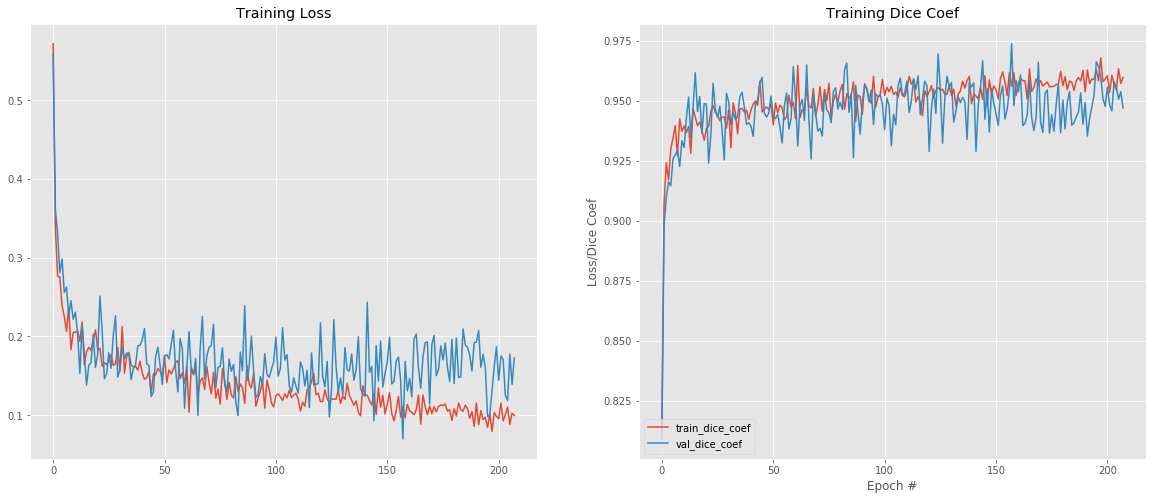

In [81]:
# Get actual number of epochs model was trained for
N = len(result.history['loss'])

#Plot the model evaluation history
plt.style.use("ggplot")
fig = plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.title("Training Loss")
plt.plot(np.arange(0, N), result.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), result.history["val_loss"], label="val_loss")
#plt.ylim(0, 1)

fig.add_subplot(1,2,2)
plt.title("Training Dice Coef")
plt.plot(np.arange(0, N), result.history["dice_coef"], label="train_dice_coef")
plt.plot(np.arange(0, N), result.history["val_dice_coef"], label="val_dice_coef")
#plt.ylim(0, 1)

plt.xlabel("Epoch #")
plt.ylabel("Loss/Dice Coef")
plt.legend(loc="lower left")
plt.show()

### Extract and display model frame, prediction and mask 

In [82]:
#Create iterators for frames and masks
X_TEST = []
Y_TEST = []
test_frame_batches = tf.compat.v1.data.make_one_shot_iterator(test_frame_tensors)  # outside of TF Eager, we would use make_one_shot_iterator
test_mask_batches = tf.compat.v1.data.make_one_shot_iterator(test_masks_tensors)

    
#Iterate over the train images while saving the frames and masks in appropriate folders
dir_name='test'
i=0
for file in zip(test_frames_list, test_masks_list):
    #Convert tensors to numpy arrays
    frame = test_frame_batches.next().numpy().astype(np.uint8)
    mask = test_mask_batches.next().numpy().astype(np.uint8)
    if mask.shape != (224, 224, 1):
            #Convert numpy arrays to images
        X_TEST.append(frame / 255.)
        Y_TEST.append(mask)
        if i%20 == 0:
            print("[INFO] Iteration num: {}".format(i))
        i +=1

[INFO] Iteration num: 0
[INFO] Iteration num: 20
[INFO] Iteration num: 40
[INFO] Iteration num: 60
[INFO] Iteration num: 80


In [85]:
X_TEST = np.asarray(X_TEST)
Y_TEST = np.array(Y_TEST)
Y_TEST_PRED = test_model.predict([X_TEST, X_TEST])
print("Test images shape: {}".format(X_TEST.shape))
print("Test masks shape: {}".format(Y_TEST.shape))
print("Test masks predict shape: {}".format(Y_TEST_PRED.shape))

Test images shape: (93, 224, 224, 3)
Test masks shape: (93, 224, 224, 3)
Test masks predict shape: (93, 224, 224, 3)


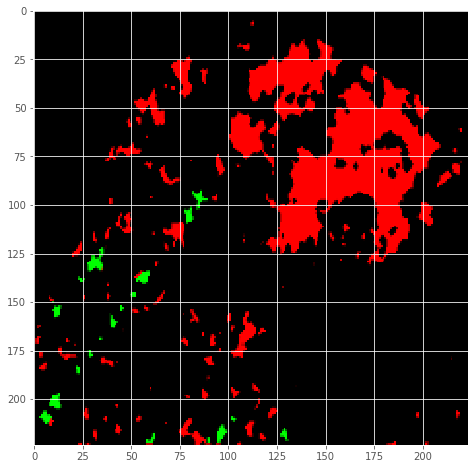

In [86]:
#Plot the the mask test image
plt.style.use("ggplot")
fig = plt.figure(figsize=(20,8))
plt.imshow(Y_TEST[1])

### Binaryze the masks and calculate the AUC score 

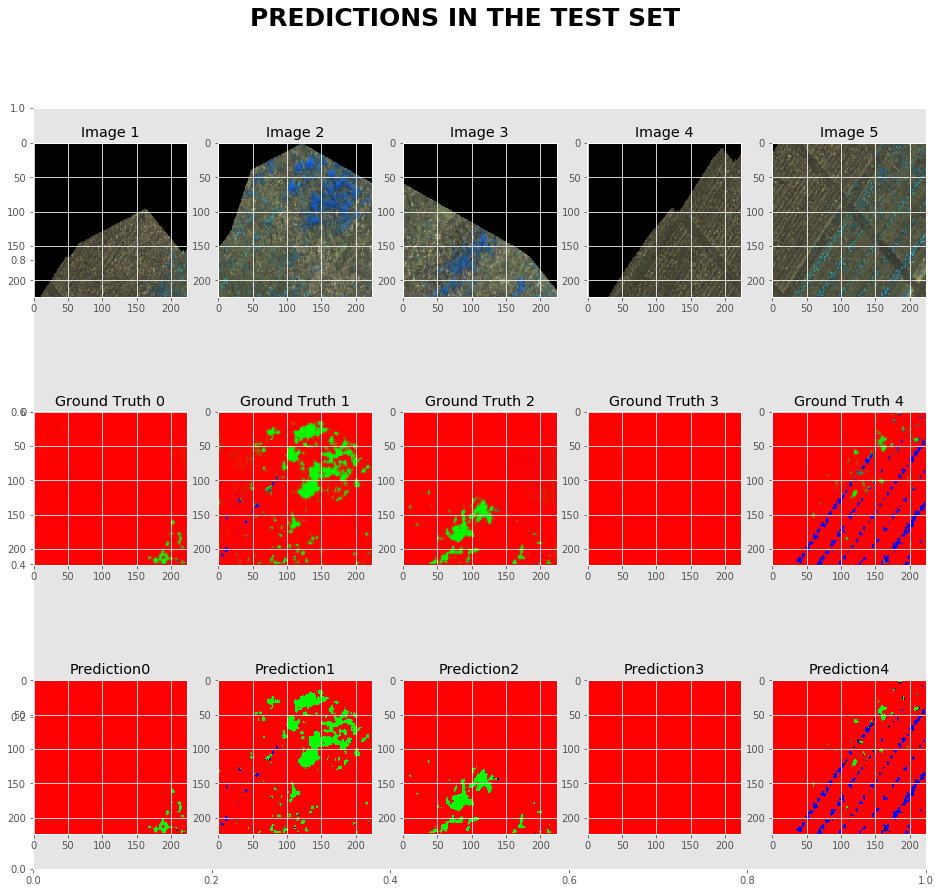

In [94]:
fig = plt.figure(figsize=(16, 14))
plt.suptitle("PREDICTIONS IN THE TEST SET", fontsize=25, fontweight="bold")
plt.grid(False)
for i in range(5):
    ax = fig.add_subplot(3, 5, i + 1)
    plt.imshow(X_TEST[i][:,:,::-1])
    plt.title("Image " + str(i + 1))

    ax = fig.add_subplot(3, 5, 5 + i + 1)
    plt.imshow(Y_TEST_PRED[i], cmap='gray', interpolation='nearest')
    plt.title("Ground Truth " + str(i))

    ax = fig.add_subplot(3, 5, i + 10 + 1)
    plt.imshow(cv2.threshold(Y_TEST_PRED[i] , 0.5 , 1 ,cv2.THRESH_BINARY)[1].squeeze(), cmap='gray', interpolation='nearest')
    plt.title("Prediction" + str(i))

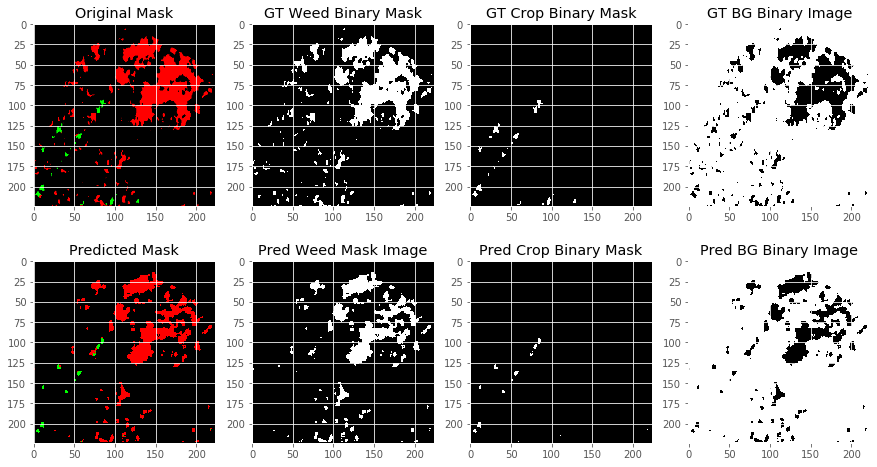

In [89]:
# ground truth color masks
image_num = 1
Y_TEST_WEED = []
Y_TEST_CROP = []
Y_TEST_BG = []
Y_TEST_PRED_WEED = []
Y_TEST_PRED_CROP = []
Y_TEST_BG = []

def rgb_to_binary_masks(mask):
    ## mask of green (36,25,25) ~ (86, 255,255)
    # mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
    _, WEED = cv2.threshold(mask[:, :, 0], 50, 255, cv2.THRESH_BINARY)
    _, CROP = cv2.threshold(mask[:, :, 1], 50, 255, cv2.THRESH_BINARY)
    BG = cv2.inRange(mask, (0, 0, 0), (50, 50, 50), cv2.THRESH_BINARY)
    
    return WEED, CROP, BG

gt_weed, gt_crop, gt_bg = rgb_to_binary_masks(Y_TEST[image_num])
pred_weed, pred_crop, pred_bg = rgb_to_binary_masks(onehot_to_rgb((Y_TEST_PRED[image_num])))


plt.figure(figsize=[15,8])
plt.subplot(241);plt.imshow(Y_TEST[image_num]);plt.title('Original Mask');
plt.subplot(242);plt.imshow(gt_weed, cmap='gray');plt.title('GT Weed Binary Mask');
plt.subplot(243);plt.imshow(gt_crop,cmap='gray');plt.title('GT Crop Binary Mask');
plt.subplot(244);plt.imshow(gt_bg,cmap='gray');plt.title('GT BG Binary Image');
plt.subplot(245);plt.imshow(onehot_to_rgb(Y_TEST_PRED[image_num]));plt.title('Predicted Mask');
plt.subplot(246);plt.imshow(pred_weed,cmap='gray');plt.title('Pred Weed Mask Image');
plt.subplot(247);plt.imshow(pred_crop,cmap='gray');plt.title('Pred Crop Binary Mask');
plt.subplot(248);plt.imshow(pred_bg,cmap='gray');plt.title('Pred BG Binary Image');

In [92]:
auc_crop_list = []
auc_weed_list = []
auc_bg_list = []
num_images = X_TEST.shape[0]
for image_num in range(num_images):
    gt_weed, gt_crop, gt_bg = rgb_to_binary_masks(Y_TEST[image_num])
    pred_weed, pred_crop, pred_bg = rgb_to_binary_masks(onehot_to_rgb((Y_TEST_PRED[image_num])))

    gt_weed_flat = gt_weed.flatten() / 255.
    gt_crop_flat = gt_crop.flatten()  / 255.
    gt_bg_flat = gt_bg.flatten() / 255.

    pred_weed_flat = pred_weed.flatten() / 255.
    pred_crop_flat = pred_crop.flatten()  / 255.
    pred_bg_flat = pred_bg.flatten() / 255.

    def roc_auc_score_FIXED(y_true, y_pred):
        if len(np.unique(y_true)) == 1: # bug in roc_auc_score
            return accuracy_score(y_true, np.rint(y_pred))
        return roc_auc_score(y_true, y_pred)
    # calculate scores
    #ns_auc = roc_auc_score(gt_weed_flat, ns_probs)
    weed_auc = roc_auc_score_FIXED(gt_weed_flat, pred_weed_flat)
    crop_auc = roc_auc_score_FIXED(gt_crop_flat, pred_crop_flat)
    bg_auc = roc_auc_score_FIXED(gt_bg_flat, pred_bg_flat)
    
    auc_crop_list.append(crop_auc)
    auc_weed_list.append(weed_auc)
    auc_bg_list.append(bg_auc)
# summarize scores

print('SegNet: Weed AUC={0:.3f}'.format(np.sum(auc_weed_list)/num_images))
print('SegNet: Crop AUC={0:.3f}'.format(np.sum(auc_crop_list)/num_images))
print('SegNet: BG AUC={0:.3f}'.format(np.sum(auc_bg_list)/num_images))

SegNet: Weed AUC=0.642
SegNet: Crop AUC=0.902
SegNet: BG AUC=0.815


| Author | AUC Weed| AUC Crop| AUC Bg|
| --- | --- |--- |--- |
| Sa, I. et. al (3CH RGB) | 0.576 |0.681 |0.607|
| Our Method (SegNet + DriuNet) (3CH RGB) | **0.642** |**0.902** |**0.815**|